In [1]:
import sys
from itertools import chain, product
from typing import List, Tuple, Optional, Any, Dict
import pandas as pd
from tqdm import tqdm

from rdkit import Chem
from rdkit.Chem import PandasTools

sys.path.append('..')
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from rhea.chem.molecule import Molecule
from src.models.egnn import EquivariantGNN
from src.models.diffusion import *
from src.preprocessing.chem import molecule_to_Data
from src.tools import *

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


In [2]:
df = pd.read_pickle('../data/QM9/raw/gdb9.pkl')

In [3]:
ATOM_TYPES = ['C', 'O', 'N', 'H', 'F', 'Cl', 'Br', 'I', 'P', 'S']

# Example predefined bond types
BOND_TYPES = [Chem.BondType.SINGLE, Chem.BondType.DOUBLE, Chem.BondType.TRIPLE, Chem.BondType.AROMATIC]

def get_atom_type_one_hot(atom: Chem.Atom) -> torch.Tensor:
    """
    Returns a one-hot encoded vector for the atom type.
    
    Args:
        atom (Chem.Atom): RDKit atom object.
    
    Returns:
        torch.Tensor: One-hot encoded atom type vector.
    """
    atom_symbol = atom.GetSymbol()
    one_hot_vector = torch.zeros(len(ATOM_TYPES), dtype=torch.float32)
    if atom_symbol in ATOM_TYPES:
        one_hot_vector[ATOM_TYPES.index(atom_symbol)] = 1.0
    return one_hot_vector

def get_bond_type_one_hot(bond: Chem.Bond) -> torch.Tensor:
    """
    Returns a one-hot encoded vector for the bond type.
    
    Args:
        bond (Chem.Bond): RDKit bond object.
    
    Returns:
        torch.Tensor: One-hot encoded bond type vector.
    """
    bond_type = bond.GetBondType()
    one_hot_vector = torch.zeros(len(BOND_TYPES), dtype=torch.float32)
    if bond_type in BOND_TYPES:
        one_hot_vector[BOND_TYPES.index(bond_type)] = 1.0
    return one_hot_vector

def molecule_to_Data(mol: Molecule, 
                     idx: int = 0,
                     target: torch.Tensor = torch.tensor([0], dtype=torch.float32)
                                ) -> Data:
    """
    Converts a molecule into a torch geometric `Data` object with noise scaling schedule.
    
    The structure of the `Data` object is as follows:
    ```
            {
                'x': torch.Tensor,                   # node features (one-hot encoded atom types)
                'edge_index': torch.Tensor,          # edges between atoms derived from covalent bonds (source_n, target_n)
                'edge_attr': torch.Tensor,           # bond features (one-hot encoded bond types)
                'y': torch.Tensor,                   # target
                'pos': torch.Tensor,                 # atomic coordinates
                'idx': torch.Tensor,                 # index of the molecule
                'name': str,                         # molecule name
                'z': torch.Tensor,                   # atomic numbers
                'complete_edge_index': torch.Tensor  # complete graph connectivity
            }
    ```
    
    Args:
        mol (Chem.Mol): The molecule.
        beta (float): Noise scaling schedule parameter.
        target (torch.Tensor, optional): The target. Defaults to torch.tensor([0], dtype=torch.float32).
    
    Returns:
        Data: The molecule as a `Data` object.
    """

    data = dict()
    data['name'] = mol.molecule.GetProp('_Name') if mol.molecule.HasProp('_Name') else "Molecule_{}".format(idx)
    data['smiles'] = Chem.MolToSmiles(mol.molecule)
    coordinates = mol.get_coordinates()
    pos = torch.tensor(coordinates, dtype=torch.float32)
    data['pos'] = pos
    
    x = []                                                                                          
    edge_index = []                                                                                 
    edge_attr = []
    bond_matrix = torch.zeros((len(mol.GetAtoms()), len(mol.GetAtoms()), len(BOND_TYPES)), dtype=torch.float32)
    
    for atom in mol.GetAtoms():

        atom_type = get_atom_type_one_hot(atom)
        x.append(atom_type)

    for bond in mol.GetBonds():

        bond_type = get_bond_type_one_hot(bond)
        bond_matrix[bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()] = bond_type
        bond_matrix[bond.GetEndAtomIdx(), bond.GetBeginAtomIdx()] = bond_type
        edge_attr.append(bond_type)
        edge_index.append([bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()])
    
    data['x'] = torch.stack(x, dim=0)
    data['edge_index'] = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    if len(edge_attr) == 0:
        edge_attr = torch.zeros((data['edge_index'].size(1), len(BOND_TYPES)), dtype=torch.float32)
    data['edge_attr'] = torch.stack(edge_attr, dim=0)
    data['z'] = data['x'][:, 1].long()
    data['idx'] = torch.tensor([idx], dtype=torch.long)

    data['complete_edge_index'] = torch.tensor([[i, j] for i in range(data['x'].size(0)) \
        for j in range(data['x'].size(0)) if i != j], dtype=torch.long).t().contiguous()

    data['y'] = target
    data['bond_matrix'] = bond_matrix

    return Data(**data)

In [4]:

m = df.ROMol.iloc[50]
#m = Chem.AddHs(m, addCoords=True) # Hs are not considered because they can be easily added later
m = Molecule(m)
d = molecule_to_Data(m, 0)
print(d)

Data(x=[5, 10], edge_index=[2, 5], edge_attr=[5, 4], y=[1], pos=[5, 3], name='Molecule_0', smiles='C1=CCOC1', z=[5], idx=[1], complete_edge_index=[2, 20], bond_matrix=[5, 5, 4])


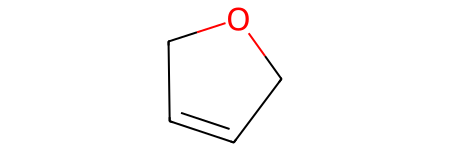

In [5]:
m

In [6]:
d

Data(x=[5, 10], edge_index=[2, 5], edge_attr=[5, 4], y=[1], pos=[5, 3], name='Molecule_0', smiles='C1=CCOC1', z=[5], idx=[1], complete_edge_index=[2, 20], bond_matrix=[5, 5, 4])

In [7]:
# dataset = []
# # Create a Dataset
# for idx, i in enumerate(tqdm(range(len(df)))):#len(df)
#     m = df.ROMol.iloc[i]
#    #m = Chem.AddHs(m, addCoords=True) # Hs are not considered because they can be easily added later
#     m = Molecule(m)
#     d = molecule_to_Data(m, idx)
#     dataset.append(d)

# Forward Process

- Adds noise to the data based on a pre-defined noise schedule.
- t denote variables at time step $t(t = 0,1,...T)$
- $M^t$ is sampled from the distribution $q(M^t | M^{t-1})$ only conditioned on $M^{t-1}$.
- For atom types and bond types we represent them using categorical distributions.
    - $q(r^{t}_i | r^{t-1}_i) := \mathcal{N}(r^{t}_i | \sqrt{1-\beta^{t} r^{t-1}_i}, \beta^{t}\mathbb{I})$
    - $q(a^{t}_i | a^{t-1}_i) := \mathcal{C}(a^{t}_i | (1-\beta^{t}) a^{t-1}_i, \beta^{t}\mathbb{1}_k)$ 
    - $q(b^{t}_{ij} | b^{t-1}_{ij}) := \mathcal{C}(b^{t}_{ij} | (1-\beta^{t}) b^{t-1}_{ij}, \beta^{t}\mathbb{1}_k)$
- $\beta^t \in [0,1]$ (noise scaling schedule).
- $\mathbb{I}^{3x3}$ is the identity matrix.
- $\mathbb{1}_k$ represents a one-hot vector with one at the kth position and all the others zeros.

In [8]:
def plot_point_cloud_3d(
    fig: mpl.figure.Figure,
    ax_pos: int,
    pos: np.ndarray,
    cmap: str = "plasma",
    point_size: float = 180.0,
    label_axes: bool = False,
    remove_axes_ticks: bool = True,
    cbar_label: str = "",
) -> mpl.axis.Axis:
    """Visualize colored 3D point clouds.

    Parameters
    ----------
    fig : mpl.figure.Figure
        The figure for which a new axis object is added for plotting
    ax_pos : int
        Three-digit integer specifying axis layout and position
        (see docs for `mpl.figure.Figure.add_subplot`)
    pos : np.ndarray
        The point xyz-coordinates as an array
    cmap : str, optional
        String identifier for a matplotlib colormap.
        Is used to map the values in `color` to rgb colors.
        , by default "plasma"
    point_size : float, optional
        The size of plotted points, by default 180.0
    label_axes : bool, optional
        whether to label x,y and z axes by default False
    annotate_points : bool, optional
        whether to label points with their index, by default True
    cbar_label : str, optional
        label for the colorbar, by default ""

    Returns
    -------
    mpl.axis.Axis
        The new axis object for the 3D point cloud plot.
    """
    cmap = mpl.colormaps.get_cmap(cmap)
    ax = fig.add_subplot(ax_pos, projection="3d")
    x, y, z = pos
    if remove_axes_ticks:
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_zticklabels([])
    if label_axes:
        ax.set_xlabel("$x$ coordinate")
        ax.set_ylabel("$y$ coordinate")
        ax.set_zlabel("$z$ coordinate")
    sc = ax.scatter(x, y, z, cmap=cmap, s=point_size)
    plt.colorbar(sc, location="bottom", shrink=0.6, anchor=(0.5, 2), label=cbar_label)
    
    return ax

def plot_model_input(data: Data, fig: mpl.figure.Figure, ax_pos: int) -> mpl.axis.Axis:
    """
    Plots 3D point cloud model input represented by a torch geometric
    `Data` object. Use atomic numbers as colors.

    Parameters
    ----------
    data : Data
        The 3D point cloud. Must have atomic numbers `z` and 2D coordinates `pos`
        properties that are not `None`.
    fig: mpl.figure.Figure
        The maptlotlib figure to plot on.
    ax_pos:
        Three-digit integer specifying axis layout and position
        (see docs for `mpl.figure.Figure.add_subplot`).

    Returns
    -------
    mpl.axis.Axis
        The newly created axis object.
    """
    pos = data.pos

    pos = pos.T.detach().numpy()
    return plot_point_cloud_3d(fig, ax_pos, pos, cbar_label="Atomic number")


C:\Users\cabe\AppData\Local\Temp\ipykernel_40872\3093895224.py:51: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = ax.scatter(x, y, z, cmap=cmap, s=point_size)


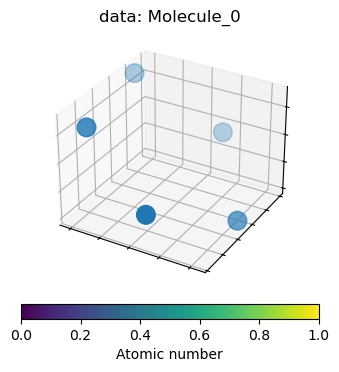

In [9]:
fig = plt.figure()
ax = plot_model_input(d, fig, 111)
_ = ax.set_title(f"data: {d['name']}")

In [10]:
def segment_schedule(timesteps: int, time_segment: list, segment_diff: list) -> torch.Tensor:
    """
    Generates a schedule for beta values over different segments.

    Parameters:
        timesteps (int): Total number of timesteps.
        time_segment (list): List of segment lengths.
        segment_diff (list): List of dictionaries with parameters for each segment.

    Returns:
        torch.Tensor: Beta values for the entire schedule.
    """
    assert np.sum(time_segment) == timesteps

    alphas_cumprod = []

    for i in range(len(time_segment)):
        time_this = time_segment[i] + 1
        params = segment_diff[i]
        _, alphas_this = advance_schedule(time_this, **params, return_alphas_bar=True)
        alphas_cumprod.extend(alphas_this[1:])

    alphas_cumprod = np.array(alphas_cumprod)
    
    alphas = np.zeros_like(alphas_cumprod)
    alphas[0] = alphas_cumprod[0]
    alphas[1:] = alphas_cumprod[1:] / alphas_cumprod[:-1]
    betas = 1 - alphas
    betas = np.clip(betas, 0, 1)

    return torch.tensor(betas, dtype=torch.float32)

def sigmoid(x: float) -> float:
    """
    Sigmoid function.
    """
    return 1 / (1 + np.exp(-x))

def advance_schedule(
        timesteps: int, 
        scale_start:float, 
        scale_end: float,
        width: int,
        return_alphas_bar: bool = False
        ) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Generates a schedule for beta values over different segments.
    """
    k = width
    A0 = scale_end
    A1 = scale_start

    a = (A0-A1)/(sigmoid(-k) - sigmoid(k))
    b = 0.5 * (A0 + A1 - a)

    x = np.linspace(-1, 1, timesteps)
    y = a * sigmoid(- k * x) + b
    # print(y)
    
    alphas_cumprod = y 
    alphas = np.zeros_like(alphas_cumprod)
    alphas[0] = alphas_cumprod[0]
    alphas[1:] = alphas_cumprod[1:] / alphas_cumprod[:-1]
    betas = 1 - alphas
    betas = np.clip(betas, 0, 1)
    if return_alphas_bar:
        return torch.tensor(betas, dtype=torch.float32), torch.tensor(alphas, dtype=torch.float32)
    return torch.tensor(betas, dtype=torch.float32)

def forward_diffusion(data: dict, t: int, timesteps:int) -> dict:
    """
    Adds noise to the molecule data based on the given noise schedule at time step t.
    
    Args:
        data (dict): The molecule data containing atom types, bond types, and positions.
        t (int): The current time step.
        betas (torch.Tensor): The noise scaling schedule tensor.
    
    Returns:
        dict: The noisy molecule data.
    """
   
    noisy_data = {}
    
    # Apply noise to positions
    betas = beta_schedule(timesteps, scale_start=0.9999, scale_end=0.0001, type='advance', width=3)
    alphas = 1 - betas
    alpha_hat = torch.cumprod(alphas, dim=0)
    pos = data['pos']
    noise = torch.randn_like(pos)
    alpha_t = alpha_hat[t]
    mean = torch.sqrt(alpha_t) * pos
    variance = torch.sqrt(1 - alpha_t) * noise
    noisy_pos = mean + variance
    noisy_data['pos'] = noisy_pos
    
    # Apply noise to atom types (Categorical noise)
    betas = beta_schedule(timesteps, scale_start=0.9999, scale_end=0.0001, type='advance', width=3)
    alphas = 1 - betas
    alpha_hat = torch.cumprod(alphas, dim=0)
    atom_types = data['x']
    alpha_t = alpha_hat[t].reshape(1, -1)
    noise = torch.rand_like(atom_types)  # Use uniform noise for categorical data
    noisy_atom_types = torch.sqrt(alpha_t) * atom_types + torch.sqrt(1 - alpha_t) * noise
    noisy_atom_types = F.softmax(noisy_atom_types, dim=-1)
    noisy_data['x'] = noisy_atom_types
    
    # Apply noise to bond types (Categorical noise)
    betas = beta_schedule(
        timesteps, 
        time_segment=[600, 400], 
        segment_diff=[
            {'scale_start': 0.9999, 'scale_end': 0.001, 'width': 3}, 
            {'scale_start': 0.001, 'scale_end': 0.0001, 'width': 2}],
            type = 'segment'
            )
    bond_types = data['edge_attr']
    alphas = 1 - betas
    alpha_hat = torch.cumprod(alphas, dim=0)
    alpha_t = alpha_hat[t].reshape(1, -1)
    noise = torch.rand_like(bond_types)  # Use uniform noise for categorical data
    noisy_bond_types = torch.sqrt(alpha_t) * bond_types + torch.sqrt(1 - alpha_t) * noise
    noisy_bond_types = F.softmax(noisy_bond_types, dim=-1)
    noisy_data['edge_attr'] = noisy_bond_types
    
    # Preserve other data
    noisy_data['edge_index'] = data['edge_index']
    noisy_data['z'] = data['z']
    noisy_data['idx'] = data['idx']
    noisy_data['complete_edge_index'] = data['complete_edge_index']
    noisy_data['y'] = data['y']
    noisy_data['name'] = data['name']
    noisy_data['smiles'] = data['smiles']
    noisy_data['bond_matrix'] = data['bond_matrix']
    
    return Data(**noisy_data)


In [11]:
T = 1000  # Total number of time steps

# Assuming `d` is your molecule data from previous code
for t in range(T):
    noisy_data = forward_diffusion(d, t, T)
    if t % 50 == 0:
        fig = plt.figure()
        ax = plot_model_input(noisy_data, fig, 111)
        _ = ax.set_title(f"Noisy data at time step {t}")
        plt.show()

TypeError: advance_schedule() got an unexpected keyword argument 'type'

In [ ]:
noisy_data.num_edge_types

1